# Loading the Training Data

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch

labels_csv_path = 'Training.csv'
df = pd.read_csv(labels_csv_path)

image_files = df['Image'].values
labels = df['Label'].values

# Split the data into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, directory, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.directory = directory
        self.transform = transform
        self.label_mapping = {
            'Normal': 0,
            'Mitosis': 1
        }

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        label_text = self.labels[idx]
        label = self.label_mapping[label_text]
        label_tensor = torch.tensor(label, dtype=torch.float32)
        
        img_path = f"{self.directory}/{img_name}"
        image = Image.open(img_path).convert('RGB')  # Ensure image is RGB

        if self.transform:
            image = self.transform(image)
        
        return image, label_tensor

# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = CustomDataset(train_files, train_labels, 'Training Images', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Images', transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Loading the Testing Data

In [7]:
class TestDataset(Dataset):
    def __init__(self, image_paths, directory, transform=None):
        self.image_paths = image_paths
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = f"{self.directory}/{img_name}"
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

test_df = pd.read_csv('Testing.csv')
test_image_files = test_df['Image'].values

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = TestDataset(test_image_files, 'Testing Image', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# EDA

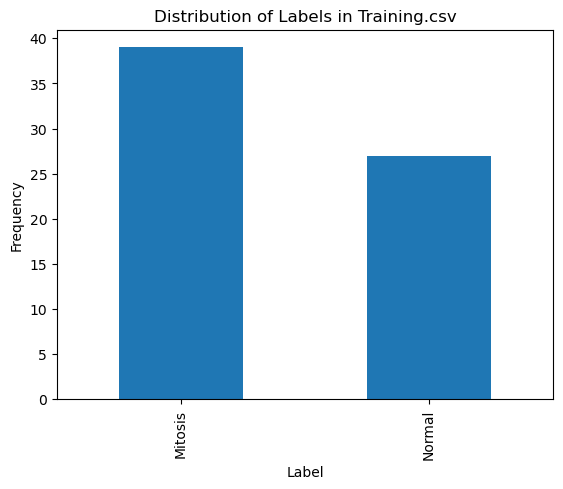

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Training.csv')

df['Label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels in Training.csv')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

# CNN

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Define transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and loaders
train_dataset = CustomDataset(train_files, train_labels, 'Training Image', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Image', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Model architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming binary classification
labels_unique = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=labels_unique, y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        train_preds, train_targets = [], []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
            preds = torch.sigmoid(outputs).data > 0.5
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds)

        model.eval()
        val_losses = []
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_losses.append(loss.item())
                
                preds = torch.sigmoid(outputs).data > 0.5
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {np.mean(val_losses):.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

model1 = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50)

Epoch 1/50, Train Loss: 9.7874, Train Acc: 0.4808, Train F1: 0.5263, Val Loss: 2.3970, Val Acc: 0.3571, Val F1: 0.0000
Epoch 2/50, Train Loss: 1.9953, Train Acc: 0.7308, Train F1: 0.7812, Val Loss: 2.4437, Val Acc: 0.3571, Val F1: 0.0000
Epoch 3/50, Train Loss: 2.8428, Train Acc: 0.7500, Train F1: 0.8060, Val Loss: 2.4792, Val Acc: 0.5000, Val F1: 0.4615
Epoch 4/50, Train Loss: 1.3122, Train Acc: 0.7115, Train F1: 0.7273, Val Loss: 0.5562, Val Acc: 0.5714, Val F1: 0.6667
Epoch 5/50, Train Loss: 1.2808, Train Acc: 0.6923, Train F1: 0.7333, Val Loss: 2.1213, Val Acc: 0.7143, Val F1: 0.8000
Epoch 6/50, Train Loss: 1.6485, Train Acc: 0.7885, Train F1: 0.8406, Val Loss: 3.0611, Val Acc: 0.6429, Val F1: 0.7619
Epoch 7/50, Train Loss: 0.8684, Train Acc: 0.8077, Train F1: 0.8214, Val Loss: 1.6238, Val Acc: 0.5714, Val F1: 0.6667
Epoch 8/50, Train Loss: 0.6335, Train Acc: 0.8462, Train F1: 0.8750, Val Loss: 0.6017, Val Acc: 0.6429, Val F1: 0.7619
Epoch 9/50, Train Loss: 0.9252, Train Acc: 0.807

# Test_Predictions_1 and 5

In [72]:
def predict(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()
            predictions.extend(preds.cpu().numpy())

    return np.array(predictions).flatten()

test_predictions = predict(model, test_loader, device)

In [73]:
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
textual_predictions = [label_mapping_inverse[pred] for pred in test_predictions]
test_df['Label'] = textual_predictions
test_df.to_csv('Test_Predictions_5.csv', index=False)

# CNN with enhancements
- early stopping
- more augmentation
- learning rate scheduler

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Define transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomPerspective(distortion_scale=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Create datasets and loaders
train_dataset = CustomDataset(train_files, train_labels, 'Training Image', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Image', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Model architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming binary classification
labels_unique = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=labels_unique, y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_loss = float('inf')
    patience = 5  # Number of epochs to wait for improvement before stopping
    patience_counter = 0  # Counter for patience
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, min_lr=1e-6, verbose=True)
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        train_preds, train_targets = [], []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
            preds = torch.sigmoid(outputs).data > 0.5
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds)

        model.eval()
        val_losses = []
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_losses.append(loss.item())
                
                preds = torch.sigmoid(outputs).data > 0.5
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds)
        
        # Early Stopping Check
        if np.mean(val_losses) < best_val_loss:
            best_val_loss = np.mean(val_losses)
            patience_counter = 0  # Reset counter
            # Save the best model
            torch.save(model.state_dict(), "best_model3.pth")
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
        scheduler.step(np.mean(val_losses))
        current_lr = scheduler.get_last_lr()[0]
        print(f'Current learning rate: {current_lr}')
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {np.mean(val_losses):.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

model3 = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20)

c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Current learning rate: 0.001
Epoch 1/20, Train Loss: 8.2311, Train Acc: 0.5962, Train F1: 0.6957, Val Loss: 2.0970, Val Acc: 0.4286, Val F1: 0.2000
Current learning rate: 0.001
Epoch 2/20, Train Loss: 1.5852, Train Acc: 0.5769, Train F1: 0.6562, Val Loss: 1.8058, Val Acc: 0.5000, Val F1: 0.3636
Current learning rate: 0.001
Epoch 3/20, Train Loss: 0.9130, Train Acc: 0.7115, Train F1: 0.7368, Val Loss: 0.9175, Val Acc: 0.6429, Val F1: 0.7619
Current learning rate: 0.001
Epoch 4/20, Train Loss: 2.8212, Train Acc: 0.6346, Train F1: 0.7595, Val Loss: 4.6052, Val Acc: 0.3571, Val F1: 0.0000
Current learning rate: 0.001
Epoch 5/20, Train Loss: 1.9443, Train Acc: 0.5192, Train F1: 0.3902, Val Loss: 0.9114, Val Acc: 0.2857, Val F1: 0.1667
Current learning rate: 0.001
Epoch 6/20, Train Loss: 1.8803, Train Acc: 0.6154, Train F1: 0.7143, Val Loss: 1.9252, Val Acc: 0.5714, Val F1: 0.6250
Current learning rate: 0.001
Epoch 7/20, Train Loss: 1.2429, Train Acc: 0.7115, Train F1: 0.7368, Val Loss: 2.00

# Test_Predictions_6

In [8]:
def predict(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()
            predictions.extend(preds.cpu().numpy())

    return np.array(predictions).flatten()

test_predictions = predict(model, test_loader, device)

In [9]:
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
textual_predictions = [label_mapping_inverse[pred] for pred in test_predictions]
test_df['Label'] = textual_predictions
test_df.to_csv('Test_Predictions_6.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Define transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomPerspective(distortion_scale=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Create datasets and loaders
train_dataset = CustomDataset(train_files, train_labels, 'Training Image', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Image', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Model architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming binary classification
labels_unique = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=labels_unique, y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_loss = float('inf')
    patience = 5  # Number of epochs to wait for improvement before stopping
    patience_counter = 0  # Counter for patience
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, min_lr=1e-6, verbose=True)
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        train_preds, train_targets = [], []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
            preds = torch.sigmoid(outputs).data > 0.5
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds)

        model.eval()
        val_losses = []
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_losses.append(loss.item())
                
                preds = torch.sigmoid(outputs).data > 0.5
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds)
        
        # Early Stopping Check
        if np.mean(val_losses) < best_val_loss:
            best_val_loss = np.mean(val_losses)
            patience_counter = 0  # Reset counter
            # Save the best model
            torch.save(model.state_dict(), "best_model3.pth")
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
        scheduler.step(np.mean(val_losses))
        current_lr = scheduler.get_last_lr()[0]
        print(f'Current learning rate: {current_lr}')
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {np.mean(val_losses):.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

model3 = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20)

c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Current learning rate: 0.001
Epoch 1/20, Train Loss: 8.2311, Train Acc: 0.5962, Train F1: 0.6957, Val Loss: 2.0970, Val Acc: 0.4286, Val F1: 0.2000
Current learning rate: 0.001
Epoch 2/20, Train Loss: 1.5852, Train Acc: 0.5769, Train F1: 0.6562, Val Loss: 1.8058, Val Acc: 0.5000, Val F1: 0.3636
Current learning rate: 0.001
Epoch 3/20, Train Loss: 0.9130, Train Acc: 0.7115, Train F1: 0.7368, Val Loss: 0.9175, Val Acc: 0.6429, Val F1: 0.7619
Current learning rate: 0.001
Epoch 4/20, Train Loss: 2.8212, Train Acc: 0.6346, Train F1: 0.7595, Val Loss: 4.6052, Val Acc: 0.3571, Val F1: 0.0000
Current learning rate: 0.001
Epoch 5/20, Train Loss: 1.9443, Train Acc: 0.5192, Train F1: 0.3902, Val Loss: 0.9114, Val Acc: 0.2857, Val F1: 0.1667
Current learning rate: 0.001
Epoch 6/20, Train Loss: 1.8803, Train Acc: 0.6154, Train F1: 0.7143, Val Loss: 1.9252, Val Acc: 0.5714, Val F1: 0.6250
Current learning rate: 0.001
Epoch 7/20, Train Loss: 1.2429, Train Acc: 0.7115, Train F1: 0.7368, Val Loss: 2.00

# Vision Transformers

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import timm
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

In [36]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(train_files, train_labels, 'Training Image', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Image', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [37]:
def dataloader_to_array(loader):
    images = []
    labels = []

    for image_batch, label_batch in loader:
        for i in range(len(image_batch)):
            # Flatten images or extract features here
            image = image_batch[i].numpy().flatten()
            images.append(image)
            labels.append(label_batch[i].item())

    return np.array(images), np.array(labels)

X_train, y_train = dataloader_to_array(train_loader)

In [38]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [39]:
from torch.utils.data import TensorDataset, DataLoader

# Convert arrays back to tensors
X_smote_tensor = torch.tensor(X_smote, dtype=torch.float).reshape((-1, 3, 224, 224))
y_smote_tensor = torch.tensor(y_smote, dtype=torch.long)

# Create a new TensorDataset and DataLoader
smote_dataset = TensorDataset(X_smote_tensor, y_smote_tensor)
train_loader = DataLoader(smote_dataset, batch_size=32, shuffle=True)

In [40]:
class ViTForBinaryClassification(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(ViTForBinaryClassification, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

model = ViTForBinaryClassification().to('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
labels_unique = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=labels_unique, y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [42]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        train_preds, train_targets = [], []  # Initialize lists to store training predictions and targets

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Convert outputs to probabilities and then to binary predictions
            preds = torch.sigmoid(outputs).data > 0.5
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Calculate and print training accuracy and F1 score
        train_acc = accuracy_score(train_targets, np.round(train_preds))
        train_f1 = f1_score(train_targets, np.round(train_preds))
        print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader)}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = torch.sigmoid(model(images))
                preds = (outputs > 0.5).int()
                val_preds.extend(preds.view(-1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
            
            val_acc = accuracy_score(val_targets, val_preds)
            val_f1 = f1_score(val_targets, val_preds)
            print(f"Validation Acc: {val_acc:.4f}, Validation F1: {val_f1:.4f}")

model2 = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)

Epoch 1, Train Loss: 1.1946452856063843, Train Acc: 0.6000, Train F1: 0.6000
Validation Acc: 0.6429, Validation F1: 0.7826
Epoch 2, Train Loss: 1.202429622411728, Train Acc: 0.5667, Train F1: 0.5938
Validation Acc: 0.3571, Validation F1: 0.0000
Epoch 3, Train Loss: 0.7471255362033844, Train Acc: 0.5000, Train F1: 0.4828
Validation Acc: 0.5000, Validation F1: 0.6667
Epoch 4, Train Loss: 0.7025513052940369, Train Acc: 0.6500, Train F1: 0.6667
Validation Acc: 0.5000, Validation F1: 0.3636
Epoch 5, Train Loss: 0.6384152770042419, Train Acc: 0.6833, Train F1: 0.6780
Validation Acc: 0.6429, Validation F1: 0.7619
Epoch 6, Train Loss: 0.6460458636283875, Train Acc: 0.7000, Train F1: 0.7692
Validation Acc: 0.5000, Validation F1: 0.3636
Epoch 7, Train Loss: 0.6178788244724274, Train Acc: 0.7000, Train F1: 0.6667
Validation Acc: 0.5714, Validation F1: 0.6667
Epoch 8, Train Loss: 0.5743424892425537, Train Acc: 0.7167, Train F1: 0.7733
Validation Acc: 0.3571, Validation F1: 0.4000
Epoch 9, Train Lo

# Test_Predictions_2

In [44]:
test_df = pd.read_csv('Testing.csv')
test_image_files = test_df['Image'].values

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = TestDataset(test_image_files, 'Testing Image', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

test_predictions = predict(model, test_loader, device)

In [45]:
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
textual_predictions = [label_mapping_inverse[pred] for pred in test_predictions]
test_df['Label'] = textual_predictions
test_df.to_csv('Test_Predictions_2.csv', index=False)

# Vision Transformer with Enhancements
- added more augmentation techniques to counter overfitting
- added learning rate scheduler

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import timm
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

In [47]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomAdjustSharpness(2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(train_files, train_labels, 'Training Image', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Image', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [48]:
def dataloader_to_array(loader):
    images = []
    labels = []

    for image_batch, label_batch in loader:
        for i in range(len(image_batch)):
            # Flatten images or extract features here
            image = image_batch[i].numpy().flatten()
            images.append(image)
            labels.append(label_batch[i].item())

    return np.array(images), np.array(labels)

X_train, y_train = dataloader_to_array(train_loader)

In [49]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [50]:
from torch.utils.data import TensorDataset, DataLoader

# Convert arrays back to tensors
X_smote_tensor = torch.tensor(X_smote, dtype=torch.float).reshape((-1, 3, 224, 224))
y_smote_tensor = torch.tensor(y_smote, dtype=torch.long)

# Create a new TensorDataset and DataLoader
smote_dataset = TensorDataset(X_smote_tensor, y_smote_tensor)
train_loader = DataLoader(smote_dataset, batch_size=32, shuffle=True)

In [51]:
class ViTForBinaryClassification(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(ViTForBinaryClassification, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

model = ViTForBinaryClassification().to('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
labels_unique = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=labels_unique, y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [53]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        train_preds, train_targets = [], []  # Initialize lists to store training predictions and targets

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Convert outputs to probabilities and then to binary predictions
            preds = torch.sigmoid(outputs).data > 0.5
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Calculate and print training accuracy and F1 score
        train_acc = accuracy_score(train_targets, np.round(train_preds))
        train_f1 = f1_score(train_targets, np.round(train_preds))
        print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader)}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        
        scheduler.step()

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = torch.sigmoid(model(images))
                preds = (outputs > 0.5).int()
                val_preds.extend(preds.view(-1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
            
            val_acc = accuracy_score(val_targets, val_preds)
            val_f1 = f1_score(val_targets, val_preds)
            print(f"Validation Acc: {val_acc:.4f}, Validation F1: {val_f1:.4f}")

model2 = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)

Epoch 1, Train Loss: 1.9885109066963196, Train Acc: 0.4667, Train F1: 0.4483
Validation Acc: 0.5000, Validation F1: 0.6667
Epoch 2, Train Loss: 0.9840219914913177, Train Acc: 0.5167, Train F1: 0.5246
Validation Acc: 0.6429, Validation F1: 0.7368
Epoch 3, Train Loss: 0.7323697209358215, Train Acc: 0.5833, Train F1: 0.7059
Validation Acc: 0.6429, Validation F1: 0.7826
Epoch 4, Train Loss: 0.6750957071781158, Train Acc: 0.6167, Train F1: 0.7229
Validation Acc: 0.3571, Validation F1: 0.0000
Epoch 5, Train Loss: 0.7038516104221344, Train Acc: 0.6500, Train F1: 0.4878
Validation Acc: 0.5714, Validation F1: 0.6667
Epoch 6, Train Loss: 0.5774530470371246, Train Acc: 0.7500, Train F1: 0.8000
Validation Acc: 0.5714, Validation F1: 0.6250
Epoch 7, Train Loss: 0.45825594663619995, Train Acc: 0.8833, Train F1: 0.8923
Validation Acc: 0.7143, Validation F1: 0.7143
Epoch 8, Train Loss: 0.4000968039035797, Train Acc: 0.8333, Train F1: 0.8214
Validation Acc: 0.4286, Validation F1: 0.5000
Epoch 9, Train 

# Test_Predictions_3

In [54]:
test_df = pd.read_csv('Testing.csv')
test_image_files = test_df['Image'].values

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = TestDataset(test_image_files, 'Testing Image', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

test_predictions = predict(model, test_loader, device)

In [55]:
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
textual_predictions = [label_mapping_inverse[pred] for pred in test_predictions]
test_df['Label'] = textual_predictions
test_df.to_csv('Test_Predictions_3.csv', index=False)

# Vision Transformer with Enhancements
- added more augmentation techniques to counter overfitting
- adjusted the scheduler

In [39]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomAdjustSharpness(2, p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(train_files, train_labels, 'Training Image', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Image', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [40]:
def dataloader_to_array(loader):
    images = []
    labels = []

    for image_batch, label_batch in loader:
        for i in range(len(image_batch)):
            # Flatten images or extract features here
            image = image_batch[i].numpy().flatten()
            images.append(image)
            labels.append(label_batch[i].item())

    return np.array(images), np.array(labels)

X_train, y_train = dataloader_to_array(train_loader)

In [41]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [42]:
from torch.utils.data import TensorDataset, DataLoader

# Convert arrays back to tensors
X_smote_tensor = torch.tensor(X_smote, dtype=torch.float).reshape((-1, 3, 224, 224))
y_smote_tensor = torch.tensor(y_smote, dtype=torch.long)

# Create a new TensorDataset and DataLoader
smote_dataset = TensorDataset(X_smote_tensor, y_smote_tensor)
train_loader = DataLoader(smote_dataset, batch_size=32, shuffle=True)

In [43]:
class ViTForBinaryClassification(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(ViTForBinaryClassification, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

model = ViTForBinaryClassification().to('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
labels_unique = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=labels_unique, y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [45]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        train_preds, train_targets = [], []  # Initialize lists to store training predictions and targets

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Convert outputs to probabilities and then to binary predictions
            preds = torch.sigmoid(outputs).data > 0.5
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Calculate and print training accuracy and F1 score
        train_acc = accuracy_score(train_targets, np.round(train_preds))
        train_f1 = f1_score(train_targets, np.round(train_preds))
        print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader)}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        
        scheduler.step()

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = torch.sigmoid(model(images))
                preds = (outputs > 0.5).int()
                val_preds.extend(preds.view(-1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
            
            val_acc = accuracy_score(val_targets, val_preds)
            val_f1 = f1_score(val_targets, val_preds)
            print(f"Validation Acc: {val_acc:.4f}, Validation F1: {val_f1:.4f}")

model2 = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)

Epoch 1, Train Loss: 1.256094366312027, Train Acc: 0.5833, Train F1: 0.6753
Validation Acc: 0.3571, Validation F1: 0.0000
Epoch 2, Train Loss: 1.0873625576496124, Train Acc: 0.6000, Train F1: 0.3684
Validation Acc: 0.6429, Validation F1: 0.7826
Epoch 3, Train Loss: 0.7187078297138214, Train Acc: 0.5833, Train F1: 0.7059
Validation Acc: 0.2857, Validation F1: 0.0000
Epoch 4, Train Loss: 0.6722207963466644, Train Acc: 0.6333, Train F1: 0.5000
Validation Acc: 0.6429, Validation F1: 0.7368
Epoch 5, Train Loss: 0.5516555309295654, Train Acc: 0.7667, Train F1: 0.7879
Validation Acc: 0.4286, Validation F1: 0.5556
Epoch 6, Train Loss: 0.4896591156721115, Train Acc: 0.7833, Train F1: 0.8000
Validation Acc: 0.4286, Validation F1: 0.4286
Epoch 7, Train Loss: 0.45933590829372406, Train Acc: 0.8000, Train F1: 0.7857
Validation Acc: 0.6429, Validation F1: 0.7368
Epoch 8, Train Loss: 0.3212045282125473, Train Acc: 0.8833, Train F1: 0.8889
Validation Acc: 0.4286, Validation F1: 0.6000
Epoch 9, Train L

In [92]:
model_save_path = 'ViT.pth'
torch.save(model.state_dict(), model_save_path)

# Test_Predictions_4

### Evaluation

In [84]:
labels_csv_path = r'C:\Users\Fatima Azfar\Desktop\AIC-2024\Round 1\Train.csv'
df = pd.read_csv(labels_csv_path)

image_files = df['Image'].values
image_files = [f"{name}.jpg" for name in image_files]
labels = df['Label'].values

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = CustomDataset(image_files, labels, r'C:\Users\Fatima Azfar\Desktop\AIC-2024\Round 1\Training Images', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)

In [85]:
def evaluate_model(model, test_loader):
    model.eval()
    test_preds, test_targets = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = torch.sigmoid(model(images))
            preds = (outputs > 0.5).int()
            test_preds.extend(preds.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())
    
    test_acc = accuracy_score(test_targets, test_preds)
    test_f1 = f1_score(test_targets, test_preds)
    print(f"Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")

evaluate_model(model, test_loader)

Test Acc: 0.5619, Test F1: 0.6236


### Predictions

In [97]:
test_df = pd.read_csv('Testing.csv')
test_image_files = test_df['Image'].values

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = TestDataset(test_image_files, 'Testing Image', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

def predict_on_test_loader(model, test_loader, device):
    model.eval()  # Ensure the model is in evaluation mode
    test_preds = []  # Initialize a list to store predictions

    with torch.no_grad():  # No need to compute gradients
        for images in test_loader:
            images = images.to(device)  # Move images to the appropriate device
            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities for binary classification
            preds = (probs > 0.5).int()  # Threshold probabilities to obtain binary predictions
            test_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy

    return np.array(test_preds).flatten()  # Flatten the list of predictions if necessary and return

# Assuming your model is named 'model2' and is already trained
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_predictions = predict_on_test_loader(model, test_loader, device)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x100352 and 41472x512)

In [ ]:
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
textual_predictions = [label_mapping_inverse[pred] for pred in test_predictions]
test_df['Label'] = textual_predictions
test_df.to_csv('Test_Predictions_4.csv', index=False)

# CNN
- added k-fold cross validation
- added more augmentation
- added smote for synthetic images to deal with imbalance
- added early dropout
- added weight decay for L2 regularization

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from torch.utils.data import SubsetRandomSampler

labels_csv_path = 'Training.csv'
df = pd.read_csv(labels_csv_path)

image_files = df['Image'].values
labels = df['Label'].values

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.05, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device):
    for epoch in range(num_epochs):
        model.train()
        train_losses, train_preds, train_targets = [], [], []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            preds = torch.sigmoid(outputs).data > 0.5
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_targets, np.round(train_preds))
        train_f1 = f1_score(train_targets, np.round(train_preds))

        model.eval()
        val_losses, val_preds, val_targets = [], [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
                preds = torch.sigmoid(outputs).data > 0.5
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds)
        
        scheduler.step()
        
        print(f'Epoch {epoch+1}, Train Loss: {np.mean(train_losses):.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {np.mean(val_losses):.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 20
k_folds = 5
learning_rate = 0.001

# Dataset and DataLoader
dataset = CustomDataset(image_files,labels,'Training Image',transform=transform)
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    # Train the model
    train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device)


FOLD 0
--------------------------------
Epoch 1, Train Loss: 8.9847, Train Acc: 0.5000, Train F1: 0.5667, Val Loss: 3.0894, Val Acc: 0.5714, Val F1: 0.7273
Epoch 2, Train Loss: 15.8683, Train Acc: 0.5962, Train F1: 0.7470, Val Loss: 1.4659, Val Acc: 0.4286, Val F1: 0.2000
Epoch 3, Train Loss: 2.9730, Train Acc: 0.5769, Train F1: 0.5000, Val Loss: 2.8231, Val Acc: 0.4286, Val F1: 0.0000
Epoch 4, Train Loss: 3.8953, Train Acc: 0.4231, Train F1: 0.2105, Val Loss: 2.2121, Val Acc: 0.5000, Val F1: 0.2222
Epoch 5, Train Loss: 2.0703, Train Acc: 0.6538, Train F1: 0.6087, Val Loss: 1.3138, Val Acc: 0.7143, Val F1: 0.7143
Epoch 6, Train Loss: 2.1033, Train Acc: 0.5769, Train F1: 0.5769, Val Loss: 2.5673, Val Acc: 0.5714, Val F1: 0.4000
Epoch 7, Train Loss: 2.0596, Train Acc: 0.5962, Train F1: 0.5714, Val Loss: 1.8020, Val Acc: 0.7143, Val F1: 0.7143
Epoch 8, Train Loss: 1.6903, Train Acc: 0.6346, Train F1: 0.6415, Val Loss: 0.7776, Val Acc: 0.7857, Val F1: 0.7692
Epoch 9, Train Loss: 1.5152, Tr

# CNN

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import torchvision.transforms.functional as TF
import random
from sklearn.utils.class_weight import compute_class_weight

class RandomVerticalFlip(object):
    """Randomly flip the image vertically."""
    def __call__(self, img):
        if random.random() > 0.5:
            return TF.vflip(img)
        return img

# Define transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.RandomPerspective(distortion_scale=0.05, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and loaders
train_dataset = CustomDataset(train_files, train_labels, 'Training Image', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Image', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Model architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming binary classification
labels_unique = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=labels_unique, y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        train_preds, train_targets = [], []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
            preds = torch.sigmoid(outputs).data > 0.5
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds)

        model.eval()
        val_losses = []
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_losses.append(loss.item())
                
                preds = torch.sigmoid(outputs).data > 0.5
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {np.mean(val_losses):.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

model1 = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20)

Epoch 1/20, Train Loss: 14.6676, Train Acc: 0.3846, Train F1: 0.5000, Val Loss: 17.1431, Val Acc: 0.3571, Val F1: 0.0000
Epoch 2/20, Train Loss: 5.5237, Train Acc: 0.4808, Train F1: 0.5424, Val Loss: 5.0760, Val Acc: 0.6429, Val F1: 0.7059
Epoch 3/20, Train Loss: 4.0492, Train Acc: 0.6923, Train F1: 0.7838, Val Loss: 2.1070, Val Acc: 0.5000, Val F1: 0.4615
Epoch 4/20, Train Loss: 2.3772, Train Acc: 0.6346, Train F1: 0.6415, Val Loss: 2.5742, Val Acc: 0.4286, Val F1: 0.2000
Epoch 5/20, Train Loss: 2.0530, Train Acc: 0.4808, Train F1: 0.4000, Val Loss: 1.9814, Val Acc: 0.7143, Val F1: 0.8000
Epoch 6/20, Train Loss: 1.1037, Train Acc: 0.6731, Train F1: 0.7733, Val Loss: 1.7738, Val Acc: 0.5000, Val F1: 0.4615
Epoch 7/20, Train Loss: 1.1419, Train Acc: 0.6538, Train F1: 0.6786, Val Loss: 1.7505, Val Acc: 0.4286, Val F1: 0.3333
Epoch 8/20, Train Loss: 0.7680, Train Acc: 0.7308, Train F1: 0.7941, Val Loss: 0.3815, Val Acc: 0.5714, Val F1: 0.7000
Epoch 9/20, Train Loss: 0.7323, Train Acc: 0.7

# Test_Predictions_7

In [12]:
def predict(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()
            predictions.extend(preds.cpu().numpy())

    return np.array(predictions).flatten()

test_predictions = predict(model, test_loader, device)

In [13]:
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
textual_predictions = [label_mapping_inverse[pred] for pred in test_predictions]
test_df['Label'] = textual_predictions
test_df.to_csv('Test_Predictions_7.csv', index=False)

# DenseNet

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import os

# Define transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.RandomPerspective(distortion_scale=0.05, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(train_files, train_labels, 'Training Image', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Image', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pretrained DenseNet model
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 1)  # Change the final layer for binary classification

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Define the early stopping instance
early_stopping = EarlyStopping(patience=5, verbose=True)

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc, train_f1 = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predictions = torch.sigmoid(outputs) > 0.5
            train_acc += accuracy_score(labels.cpu(), predictions.cpu())
            train_f1 += f1_score(labels.cpu(), predictions.cpu(), zero_division=1)
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        train_f1 = train_f1 / len(train_loader)

        # Validation phase
        model.eval()
        val_loss, val_acc, val_f1 = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predictions = torch.sigmoid(outputs) > 0.5
                val_acc += accuracy_score(labels.cpu(), predictions.cpu())
                val_f1 += f1_score(labels.cpu(), predictions.cpu(), zero_division=1)
        
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)
        val_f1 = val_f1 / len(val_loader)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

        scheduler.step(val_loss)
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)

train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=10)

c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Train Loss: 0.7282, Train Acc: 0.6000, Train F1: 0.7189, Val Loss: 0.8487, Val Acc: 0.5000, Val F1: 0.4615
Epoch 2, Train Loss: 0.5278, Train Acc: 0.6937, Train F1: 0.7184, Val Loss: 0.8141, Val Acc: 0.7143, Val F1: 0.8182
Epoch 3, Train Loss: 0.5482, Train Acc: 0.7812, Train F1: 0.8250, Val Loss: 1.1309, Val Acc: 0.6429, Val F1: 0.7368
EarlyStopping counter: 1 out of 5
Epoch 4, Train Loss: 0.4395, Train Acc: 0.7906, Train F1: 0.8269, Val Loss: 1.0953, Val Acc: 0.5714, Val F1: 0.6667
EarlyStopping counter: 2 out of 5
Epoch 5, Train Loss: 0.4596, Train Acc: 0.8219, Train F1: 0.8571, Val Loss: 0.8795, Val Acc: 0.5714, Val F1: 0.6250
EarlyStopping counter: 3 out of 5
Epoch 6, Train Loss: 0.3512, Train Acc: 0.8063, Train F1: 0.8409, Val Loss: 2.1732, Val Acc: 0.5714, Val F1: 0.6667
EarlyStopping counter: 4 out of 5
Epoch 7, Train Loss: 0.3760, Train Acc: 0.7812, Train F1: 0.8124, Val Loss: 1.8346, Val Acc: 0.6429, Val F1: 0.7368
EarlyStopping counter: 5 out of 5
Early stopping


# Test_Predictions_8

In [23]:
def predict(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            predicted_labels = (probs > 0.5).int()
            predictions.extend(predicted_labels.cpu().numpy())
    return predictions

predictions = predict(model, test_loader, device)

predictions = np.array(predictions).flatten()

print("Predictions:", predictions)

Predictions: [1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1]


In [24]:
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
textual_predictions = [label_mapping_inverse[pred] for pred in predictions]
test_df['Label'] = textual_predictions
test_df.to_csv('Test_Predictions_8.csv', index=False)

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Define transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and loaders
train_dataset = CustomDataset(train_files, train_labels, 'Training Image', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Image', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Model architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming binary classification
labels_unique = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=labels_unique, y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        train_preds, train_targets = [], []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
            preds = torch.sigmoid(outputs).data > 0.5
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds)

        model.eval()
        val_losses = []
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_losses.append(loss.item())
                
                preds = torch.sigmoid(outputs).data > 0.5
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {np.mean(val_losses):.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

model1 = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50)

Epoch 1/50, Train Loss: 10.2827, Train Acc: 0.4615, Train F1: 0.5000, Val Loss: 13.6732, Val Acc: 0.3571, Val F1: 0.0000
Epoch 2/50, Train Loss: 1.9112, Train Acc: 0.7885, Train F1: 0.8254, Val Loss: 0.6401, Val Acc: 0.3571, Val F1: 0.0000
Epoch 3/50, Train Loss: 2.5481, Train Acc: 0.7885, Train F1: 0.8358, Val Loss: 5.8899, Val Acc: 0.4286, Val F1: 0.3333
Epoch 4/50, Train Loss: 1.8944, Train Acc: 0.6731, Train F1: 0.6792, Val Loss: 2.5677, Val Acc: 0.4286, Val F1: 0.3333
Epoch 5/50, Train Loss: 0.6912, Train Acc: 0.8269, Train F1: 0.8525, Val Loss: 1.1937, Val Acc: 0.6429, Val F1: 0.7368
Epoch 6/50, Train Loss: 1.2663, Train Acc: 0.7885, Train F1: 0.8406, Val Loss: 0.3622, Val Acc: 0.7143, Val F1: 0.7778
Epoch 7/50, Train Loss: 0.9847, Train Acc: 0.7115, Train F1: 0.7458, Val Loss: 0.8222, Val Acc: 0.5714, Val F1: 0.6250
Epoch 8/50, Train Loss: 1.0931, Train Acc: 0.8269, Train F1: 0.8364, Val Loss: 0.5637, Val Acc: 0.5714, Val F1: 0.6667
Epoch 9/50, Train Loss: 0.9992, Train Acc: 0.8